In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.options.display.max_columns = 1000
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

# 1. Load Data

In [2]:
# Load each data file into a data frame
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv", sep=",")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv", sep=",")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv", sep=",")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv", sep=",")
sales_train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv", sep=",")

# 2. Explore Data

In [3]:
# View each dataset
display(item_categories.head(1))
display(items.head(1))
display(shops.head(1))
display(test.head(1))
display(sales_train.head(1))

# Check for null values in sales_train
print("-------------------------------------------")
print("\nNull values:")
display(sales_train.isnull().sum())
print("-------------------------------------------")

# Check columns in sales_train
display(sales_train.info())
print("-------------------------------------------")
print("Max value in col 'item_cnt_day': ", sales_train['item_cnt_day'].max())
print("Min value in col 'item_cnt_day': ", sales_train['item_cnt_day'].min())
print("-------------------------------------------")

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


,ID,shop_id,item_id
0,0,5,5037


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


-------------------------------------------

Null values:


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


None

-------------------------------------------
Max value in col 'item_cnt_day':  2169.0
Min value in col 'item_cnt_day':  -22.0
-------------------------------------------


**Observations:**

No null values in col 'sales_train'

# 3. Data Preprocessing

**3.1 Find Outliers**

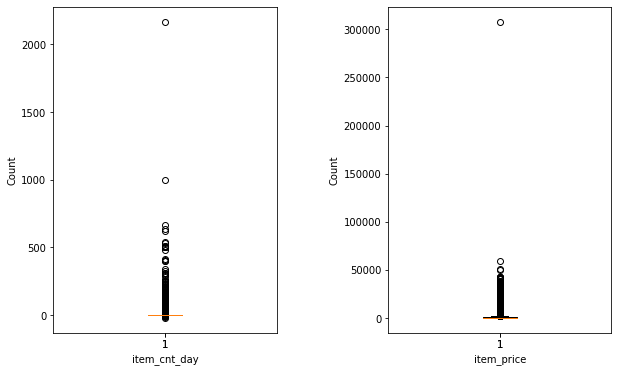

In [4]:
# Find outliers in the columns sales_train.'item_cnt_day',sales_train.'item_price'
cols = ['item_cnt_day','item_price']
fig, ax = plt.subplots(ncols = len(cols), figsize = (5 * len(cols),6), sharex = True)
fig.subplots_adjust(wspace=0.5)

for i in range(len(cols)):
  ax[i].boxplot(sales_train[cols[i]])
  ax[i].set_xlabel(cols[i])
  ax[i].set_ylabel("Count")

**Observations:**
* item_cnt_day has outlier > 2000
* item_price has outlier > 300000

**Next:**
* Remove observed outliers

In [5]:
# Remove Outliers
outlier1 = sales_train[sales_train['item_cnt_day'] > 2000].index[0]
outlier2 = sales_train[sales_train['item_price'] > 300000].index[0]
sales_train.drop([outlier1,outlier2], axis = 0, inplace = True)

# Reset index
sales_train.reset_index(inplace=True,drop=True)

**3.2 Find Anomalies**

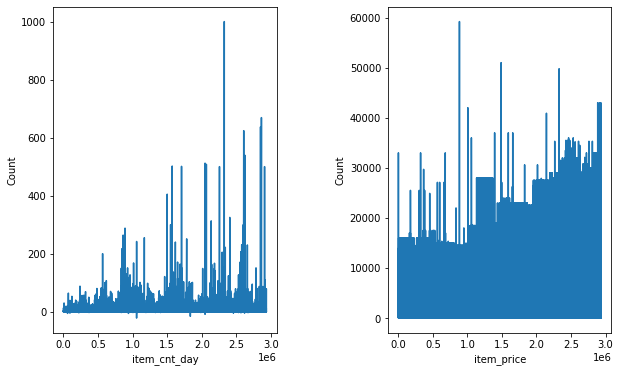

In [6]:
# Find anomalies in the columns sales_train.'item_cnt_day',sales_train.'item_price'
cols = ['item_cnt_day','item_price']
fig, ax = plt.subplots(ncols = len(cols), figsize = (5 * len(cols),6), sharex = True)
fig.subplots_adjust(wspace=0.5)

for i in range(len(cols)):
  ax[i].plot(sales_train[cols[i]])
  ax[i].set_xlabel(cols[i])
  ax[i].set_ylabel("Count")

**Observations:**

* Column 'item_cnt_day' has some negative values which could be items that were 'returned'. Since we will be considering monthly counts, we will leave the negative values in there so that we get a correct count of items sold when we aggregrate by month

# 4. Feature Engineering

In [7]:
# Get maximum number in column 'date_block_num' representing the last month in data
sales_train_max_month = sales_train.date_block_num.max()

# Add column 'date_block_num' to the test dataset. The values would be sales_train_max_month + 1 representing next month
test['date_block_num'] = sales_train_max_month + 1

# Create temp table to concat modified sales_train and test datasets
sales_temp = pd.concat([sales_train,test])

# Create monthly sales data by aggregating on column 'item_cnt_day' and then rename column to 'item_cnt_month'
sales_monthly = sales_temp.groupby(by = ['date_block_num','shop_id','item_id'], as_index=False).agg({'item_cnt_day':'sum'})
sales_monthly = sales_monthly.rename(columns={'item_cnt_day':'item_cnt_month'})

**4.1 Add Lag Feature**

In [8]:
# Add new lag column 'lag_item_cnt_month' by shifting values from 'item_cnt_month' by 1
sales_monthly['lag_item_cnt_month'] = sales_monthly['item_cnt_month'].shift(1)

# Remove na values in the lag column
sales_monthly.fillna(0, inplace=True)
sales_monthly.isna().sum()

date_block_num        0
shop_id               0
item_id               0
item_cnt_month        0
lag_item_cnt_month    0
dtype: int64

# 5. Data Preparation

In [9]:
# The 'date_block_num' must be split as contiguos months of training data and validation data
split_ratio = 0.8
train_valid_split = np.floor(sales_train_max_month*split_ratio)
train_data = sales_monthly[sales_monthly['date_block_num'] <= train_valid_split]
valid_data = sales_monthly[(sales_monthly['date_block_num'] > train_valid_split) & (sales_monthly['date_block_num'] < sales_train_max_month+1)]

# Test data will be the 'date_block_num' is sales_train_max_month+1
test_data = sales_monthly[sales_monthly['date_block_num'] == sales_train_max_month+1]

In [10]:
# Create X and y variables for train, validation and test sets
X_train = train_data.drop('item_cnt_month',axis=1)
y_train = train_data['item_cnt_month']

X_valid = valid_data.drop('item_cnt_month',axis=1)
y_valid = valid_data['item_cnt_month']

X_test = test_data.drop('item_cnt_month',axis=1)
y_test = test_data['item_cnt_month']

# 6. Model Training and Prediction

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Fit linear regression model to training set
model = LinearRegression()
model.fit(X_train,y_train)

# Use model to Predict labels for validation and test sets 
train_pred =  model.predict(X_train)
valid_pred = model.predict(X_valid)
test_pred = model.predict(X_test)

# Error metrics
print(f'Root Mean Square Train Data = {np.sqrt(mean_squared_error(y_train,train_pred))}')
print(f'Root Mean Square Validation Data = {np.sqrt(mean_squared_error(y_valid,valid_pred))}')  

Root Mean Square Train Data = 8.117034222606708
Root Mean Square Validation Data = 9.860192643190723


**Submit Predictions**

In [12]:
submission = pd.DataFrame(test['ID'])
submission['item_cnt_month'] = model.predict(X_test)
submission.to_csv('submission.csv',index=False)